In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path
sys.path.insert(1, str(Path(os.getcwd()).parent / "src"))

In [3]:
import numpy as np
import data_loader
import config
import pmcx
from matplotlib import pyplot as plt
from mcs_function import SimulationAttenuation
from plotting import *
import time

In [4]:
pmcx.gpuinfo()

[{'name': 'Quadro RTX 8000',
  'id': 1,
  'devcount': 8,
  'major': 7,
  'minor': 5,
  'globalmem': 50953846784,
  'constmem': 65536,
  'sharedmem': 49152,
  'regcount': 65536,
  'clock': 1770000,
  'sm': 72,
  'core': 4608,
  'autoblock': 64,
  'autothread': 147456,
  'maxgate': 0},
 {'name': 'Quadro RTX 8000',
  'id': 2,
  'devcount': 8,
  'major': 7,
  'minor': 5,
  'globalmem': 50953846784,
  'constmem': 65536,
  'sharedmem': 49152,
  'regcount': 65536,
  'clock': 1770000,
  'sm': 72,
  'core': 4608,
  'autoblock': 64,
  'autothread': 147456,
  'maxgate': 0},
 {'name': 'Quadro RTX 8000',
  'id': 3,
  'devcount': 8,
  'major': 7,
  'minor': 5,
  'globalmem': 50953846784,
  'constmem': 65536,
  'sharedmem': 49152,
  'regcount': 65536,
  'clock': 1770000,
  'sm': 72,
  'core': 4608,
  'autoblock': 64,
  'autothread': 147456,
  'maxgate': 0},
 {'name': 'Quadro RTX 8000',
  'id': 4,
  'devcount': 8,
  'major': 7,
  'minor': 5,
  'globalmem': 50953846784,
  'constmem': 65536,
  'sharedme

In [5]:
config.gpuid

4

In [6]:
config.mcs_func_path

PosixPath('/home/leon_ivan/data/mcs_function_data/function_data.npz')

In [7]:
mu_s_bounds = np.concatenate((
    data_loader.DataLoader.mu_s_red_func_gray_matter(np.array([450, 1000])) / (1-0.85),
    data_loader.DataLoader.mu_s_red_func_blood_vessel(np.array([450, 1000])) / (1-0.935)
))
print(mu_s_bounds)

[376.62903055  31.96592289 362.83507885 214.20496206]


In [8]:
mu_s_vals = np.linspace(10, 500, 30)
print(mu_s_vals)

[ 10.          26.89655172  43.79310345  60.68965517  77.5862069
  94.48275862 111.37931034 128.27586207 145.17241379 162.06896552
 178.96551724 195.86206897 212.75862069 229.65517241 246.55172414
 263.44827586 280.34482759 297.24137931 314.13793103 331.03448276
 347.93103448 364.82758621 381.72413793 398.62068966 415.51724138
 432.4137931  449.31034483 466.20689655 483.10344828 500.        ]


In [9]:
g_combined = 0.8675
refractive_index_combined = 1.38

In [10]:
# very deep tissue necessary, since no absorption allows photons to go deep into tissue
# for faster and statiscally better results, increasy voxel size
vol = np.ones((50, 50, 1000))
prop = np.array([[0, 0, 1, 1], [0, 0, g_combined, refractive_index_combined]])
unitinmm = 10

cfg = {
    "nphoton": 5e4, # keep nphotons relatively low, to limit memory of stored data
    "maxdetphoton": 5e4,
    "unitinmm": unitinmm,
    "vol": vol,
    "tstart":0,
    "tend":5e-7,
    "tstep":5e-7,
    "autopilot": 1,
    "gpuid": config.gpuid,
    "prop":prop,
    "bc": "ccrcca001000", # mark z=0 plane as detector
    "srcdir": [0,0,1],
    "srctype": "planar",
    "srcpos": [0, 0, 0],
    "srcparam1": [vol.shape[0], 0, 0, 0], # 3D position of vertex, fourth coordinate is irrelevant
    "srcparam2": [0, vol.shape[1], 0, 0],
    "issrcfrom0": 1,
    "savedetflag": "dps", # detector id, path length, scatter count
    "flog": config.mcs_func_path / "log.txt",
}

In [17]:
function_data = []
function_data.append(cfg["nphoton"])
function_data.append(cfg["prop"][1, 2])
function_data.append(mu_s_vals)

In [18]:
for i, mu_s in enumerate(mu_s_vals):
    cfg["prop"][1, 1] = mu_s / 10 # mu_s_vals are stored in cm^-1
    cfg["prop"][1, 0] = 0
    cfg["prop"][1, 2] = g_combined
    cfg["prop"][1, 3] = refractive_index_combined
    print(f"Iteration {i}/{len(mu_s_vals)}")
    res = pmcx.mcxlab(cfg)
    cur_photon_data = np.row_stack(
        (
            res["detp"]["ppath"][:, 0] * cfg["unitinmm"] / 10, # store pathlength in cm. pathlengths are stored in "unitinmm"
            res["detp"]["nscat"][:, 0]
        )
    )
    print(f"Mean path length: {pmcx.utils.meanpath(res['detp'])}")
    function_data.append(cur_photon_data)

np.savez(config.mcs_func_path, *function_data)

Iteration 0/30
nphoton: 100000
tstart: 0
tstep: 5e-07
tend: 5e-07
maxdetphoton: 100000
issrcfrom0: 1
autopilot: 1
unitinmm: 10
Mean path length: [2454.64135126]
Iteration 1/30
nphoton: 100000
tstart: 0
tstep: 5e-07
tend: 5e-07
maxdetphoton: 100000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Mean path length: [1518.46863527]
Iteration 2/30
nphoton: 100000
tstart: 0
tstep: 5e-07
tend: 5e-07
maxdetphoton: 100000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


                                      #
#Please visit our free scientific data sharing portal at https://neurojson.io #
# and consider sharing your public datasets in standardized JSON/JData format #
###############################################################################
$Rev::0fcc04 $ v2025 $Date::2025-02-12 23:26:11 -05$ by $Author::Qianqian Fang$
###############################################################################
- code name: [Fermi MCX] compiled by nvcc [9.2] for CUDA-arch [350] on [Feb 13 2025]
- compiled with: RNG [xorshift128+] with Seed Length [4]

GPU=4 (Quadro RTX 8000) threadph=0 extra=100000 np=100000 nthread=147456 maxgate=1 repetition=1
initializing streams ...	init complete : 3 ms
requesting 1792 bytes of shared memory
launching MCX simulation for time window [0.00e+00ns 5.00e+02ns] ...
simulation run# 1 ... 
kernel complete:  	824 ms
retrieving fields ... 	detected 98604 photons, total: 98604	transfer complete:	830 ms
normalizing raw data ...	source 

Mean path length: [1192.8521877]
Iteration 3/30
nphoton: 100000
tstart: 0
tstep: 5e-07
tend: 5e-07
maxdetphoton: 100000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Mean path length: [993.46648793]
Iteration 4/30
nphoton: 100000
tstart: 0
tstep: 5e-07
tend: 5e-07
maxdetphoton: 100000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Mean path length: [877.21221594]
Iteration 5/30
nphoton: 100000
tstart: 0
tstep: 5e-07
tend: 5e-07
maxdetphoton: 100000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Mean path length: [802.02156217]
Iteration 6/30
nphoton: 100000
tstart: 0
tstep: 5e-07
tend: 5e-07
maxdetphoton: 100000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Mean path length: [742.98461678]
Iteration 7/30
nphoton: 100000
tstart: 0
tstep: 5e-07
tend: 5e-07
maxdetphoton: 100000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Mean path length: [694.43721101]
Iteration 8/30
nphoton: 100000
tstart: 0
tstep: 5e-07
tend: 5e-07
maxdetphoton: 100000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Mean path length: [642.104048]
Iteration 9/30
nphoton: 100000
tstart: 0
tstep: 5e-07
tend: 5e-07
maxdetphoton: 100000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Mean path length: [600.27641716]
Iteration 10/30
nphoton: 100000
tstart: 0
tstep: 5e-07
tend: 5e-07
maxdetphoton: 100000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Mean path length: [564.90947383]
Iteration 11/30
nphoton: 100000
tstart: 0
tstep: 5e-07
tend: 5e-07
maxdetphoton: 100000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Mean path length: [547.00886719]
Iteration 12/30
nphoton: 100000
tstart: 0
tstep: 5e-07
tend: 5e-07
maxdetphoton: 100000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


                                      #
#Please visit our free scientific data sharing portal at https://neurojson.io #
# and consider sharing your public datasets in standardized JSON/JData format #
###############################################################################
$Rev::0fcc04 $ v2025 $Date::2025-02-12 23:26:11 -05$ by $Author::Qianqian Fang$
###############################################################################
- code name: [Fermi MCX] compiled by nvcc [9.2] for CUDA-arch [350] on [Feb 13 2025]
- compiled with: RNG [xorshift128+] with Seed Length [4]

GPU=4 (Quadro RTX 8000) threadph=0 extra=100000 np=100000 nthread=147456 maxgate=1 repetition=1
initializing streams ...	init complete : 3 ms
requesting 1792 bytes of shared memory
launching MCX simulation for time window [0.00e+00ns 5.00e+02ns] ...
simulation run# 1 ... 
kernel complete:  	3713 ms
retrieving fields ... 	detected 99455 photons, total: 99455	transfer complete:	3727 ms
normalizing raw data ...	sourc

Mean path length: [524.37939205]
Iteration 13/30
nphoton: 100000
tstart: 0
tstep: 5e-07
tend: 5e-07
maxdetphoton: 100000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Mean path length: [506.80082716]
Iteration 14/30
nphoton: 100000
tstart: 0
tstep: 5e-07
tend: 5e-07
maxdetphoton: 100000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


                                      #
#Please visit our free scientific data sharing portal at https://neurojson.io #
# and consider sharing your public datasets in standardized JSON/JData format #
###############################################################################
$Rev::0fcc04 $ v2025 $Date::2025-02-12 23:26:11 -05$ by $Author::Qianqian Fang$
###############################################################################
- code name: [Fermi MCX] compiled by nvcc [9.2] for CUDA-arch [350] on [Feb 13 2025]
- compiled with: RNG [xorshift128+] with Seed Length [4]

GPU=4 (Quadro RTX 8000) threadph=0 extra=100000 np=100000 nthread=147456 maxgate=1 repetition=1
initializing streams ...	init complete : 3 ms
requesting 1792 bytes of shared memory
launching MCX simulation for time window [0.00e+00ns 5.00e+02ns] ...
simulation run# 1 ... 
kernel complete:  	4215 ms
retrieving fields ... 	detected 99495 photons, total: 99495	transfer complete:	4220 ms
normalizing raw data ...	sourc

Mean path length: [498.35579428]
Iteration 15/30
nphoton: 100000
tstart: 0
tstep: 5e-07
tend: 5e-07
maxdetphoton: 100000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


                                      #
#Please visit our free scientific data sharing portal at https://neurojson.io #
# and consider sharing your public datasets in standardized JSON/JData format #
###############################################################################
$Rev::0fcc04 $ v2025 $Date::2025-02-12 23:26:11 -05$ by $Author::Qianqian Fang$
###############################################################################
- code name: [Fermi MCX] compiled by nvcc [9.2] for CUDA-arch [350] on [Feb 13 2025]
- compiled with: RNG [xorshift128+] with Seed Length [4]

GPU=4 (Quadro RTX 8000) threadph=0 extra=100000 np=100000 nthread=147456 maxgate=1 repetition=1
initializing streams ...	init complete : 4 ms
requesting 1792 bytes of shared memory
launching MCX simulation for time window [0.00e+00ns 5.00e+02ns] ...
simulation run# 1 ... 
kernel complete:  	4354 ms
retrieving fields ... 	detected 99520 photons, total: 99520	transfer complete:	4366 ms
normalizing raw data ...	sourc

Mean path length: [480.1167347]
Iteration 16/30
nphoton: 100000
tstart: 0
tstep: 5e-07
tend: 5e-07
maxdetphoton: 100000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


                                      #
#Please visit our free scientific data sharing portal at https://neurojson.io #
# and consider sharing your public datasets in standardized JSON/JData format #
###############################################################################
$Rev::0fcc04 $ v2025 $Date::2025-02-12 23:26:11 -05$ by $Author::Qianqian Fang$
###############################################################################
- code name: [Fermi MCX] compiled by nvcc [9.2] for CUDA-arch [350] on [Feb 13 2025]
- compiled with: RNG [xorshift128+] with Seed Length [4]

GPU=4 (Quadro RTX 8000) threadph=0 extra=100000 np=100000 nthread=147456 maxgate=1 repetition=1
initializing streams ...	init complete : 2 ms
requesting 1792 bytes of shared memory
launching MCX simulation for time window [0.00e+00ns 5.00e+02ns] ...
simulation run# 1 ... 
kernel complete:  	4419 ms
retrieving fields ... 	detected 99533 photons, total: 99533	transfer complete:	4425 ms
normalizing raw data ...	sourc

Mean path length: [460.87105641]
Iteration 17/30
nphoton: 100000
tstart: 0
tstep: 5e-07
tend: 5e-07
maxdetphoton: 100000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Mean path length: [444.42822406]
Iteration 18/30
nphoton: 100000
tstart: 0
tstep: 5e-07
tend: 5e-07
maxdetphoton: 100000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Mean path length: [429.52489728]
Iteration 19/30
nphoton: 100000
tstart: 0
tstep: 5e-07
tend: 5e-07
maxdetphoton: 100000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Mean path length: [417.08245778]
Iteration 20/30
nphoton: 100000
tstart: 0
tstep: 5e-07
tend: 5e-07
maxdetphoton: 100000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


                                      #
#Please visit our free scientific data sharing portal at https://neurojson.io #
# and consider sharing your public datasets in standardized JSON/JData format #
###############################################################################
$Rev::0fcc04 $ v2025 $Date::2025-02-12 23:26:11 -05$ by $Author::Qianqian Fang$
###############################################################################
- code name: [Fermi MCX] compiled by nvcc [9.2] for CUDA-arch [350] on [Feb 13 2025]
- compiled with: RNG [xorshift128+] with Seed Length [4]

GPU=4 (Quadro RTX 8000) threadph=0 extra=100000 np=100000 nthread=147456 maxgate=1 repetition=1
initializing streams ...	init complete : 4 ms
requesting 1792 bytes of shared memory
launching MCX simulation for time window [0.00e+00ns 5.00e+02ns] ...
simulation run# 1 ... 
kernel complete:  	5175 ms
retrieving fields ... 	detected 99568 photons, total: 99568	transfer complete:	5187 ms
normalizing raw data ...	sourc

Mean path length: [405.59255089]
Iteration 21/30
nphoton: 100000
tstart: 0
tstep: 5e-07
tend: 5e-07
maxdetphoton: 100000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


                                      #
#Please visit our free scientific data sharing portal at https://neurojson.io #
# and consider sharing your public datasets in standardized JSON/JData format #
###############################################################################
$Rev::0fcc04 $ v2025 $Date::2025-02-12 23:26:11 -05$ by $Author::Qianqian Fang$
###############################################################################
- code name: [Fermi MCX] compiled by nvcc [9.2] for CUDA-arch [350] on [Feb 13 2025]
- compiled with: RNG [xorshift128+] with Seed Length [4]

GPU=4 (Quadro RTX 8000) threadph=0 extra=100000 np=100000 nthread=147456 maxgate=1 repetition=1
initializing streams ...	init complete : 3 ms
requesting 1792 bytes of shared memory
launching MCX simulation for time window [0.00e+00ns 5.00e+02ns] ...
simulation run# 1 ... 
kernel complete:  	5612 ms
retrieving fields ... 	detected 99575 photons, total: 99575	transfer complete:	5630 ms
normalizing raw data ...	sourc

Mean path length: [392.73126896]
Iteration 22/30
nphoton: 100000
tstart: 0
tstep: 5e-07
tend: 5e-07
maxdetphoton: 100000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Mean path length: [385.31553741]
Iteration 23/30
nphoton: 100000
tstart: 0
tstep: 5e-07
tend: 5e-07
maxdetphoton: 100000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


                                      #
#Please visit our free scientific data sharing portal at https://neurojson.io #
# and consider sharing your public datasets in standardized JSON/JData format #
###############################################################################
$Rev::0fcc04 $ v2025 $Date::2025-02-12 23:26:11 -05$ by $Author::Qianqian Fang$
###############################################################################
- code name: [Fermi MCX] compiled by nvcc [9.2] for CUDA-arch [350] on [Feb 13 2025]
- compiled with: RNG [xorshift128+] with Seed Length [4]

GPU=4 (Quadro RTX 8000) threadph=0 extra=100000 np=100000 nthread=147456 maxgate=1 repetition=1
initializing streams ...	init complete : 3 ms
requesting 1792 bytes of shared memory
launching MCX simulation for time window [0.00e+00ns 5.00e+02ns] ...
simulation run# 1 ... 
kernel complete:  	6147 ms
retrieving fields ... 	detected 99590 photons, total: 99590	transfer complete:	6159 ms
normalizing raw data ...	sourc

Mean path length: [376.22151151]
Iteration 24/30
nphoton: 100000
tstart: 0
tstep: 5e-07
tend: 5e-07
maxdetphoton: 100000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


                                      #
#Please visit our free scientific data sharing portal at https://neurojson.io #
# and consider sharing your public datasets in standardized JSON/JData format #
###############################################################################
$Rev::0fcc04 $ v2025 $Date::2025-02-12 23:26:11 -05$ by $Author::Qianqian Fang$
###############################################################################
- code name: [Fermi MCX] compiled by nvcc [9.2] for CUDA-arch [350] on [Feb 13 2025]
- compiled with: RNG [xorshift128+] with Seed Length [4]

GPU=4 (Quadro RTX 8000) threadph=0 extra=100000 np=100000 nthread=147456 maxgate=1 repetition=1
initializing streams ...	init complete : 3 ms
requesting 1792 bytes of shared memory
launching MCX simulation for time window [0.00e+00ns 5.00e+02ns] ...
simulation run# 1 ... 
kernel complete:  	6241 ms
retrieving fields ... 	detected 99597 photons, total: 99597	transfer complete:	6258 ms
normalizing raw data ...	sourc

Mean path length: [371.15086419]
Iteration 25/30
nphoton: 100000
tstart: 0
tstep: 5e-07
tend: 5e-07
maxdetphoton: 100000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


                                      #
#Please visit our free scientific data sharing portal at https://neurojson.io #
# and consider sharing your public datasets in standardized JSON/JData format #
###############################################################################
$Rev::0fcc04 $ v2025 $Date::2025-02-12 23:26:11 -05$ by $Author::Qianqian Fang$
###############################################################################
- code name: [Fermi MCX] compiled by nvcc [9.2] for CUDA-arch [350] on [Feb 13 2025]
- compiled with: RNG [xorshift128+] with Seed Length [4]

GPU=4 (Quadro RTX 8000) threadph=0 extra=100000 np=100000 nthread=147456 maxgate=1 repetition=1
initializing streams ...	init complete : 2 ms
requesting 1792 bytes of shared memory
launching MCX simulation for time window [0.00e+00ns 5.00e+02ns] ...
simulation run# 1 ... 
kernel complete:  	6630 ms
retrieving fields ... 	detected 99606 photons, total: 99606	transfer complete:	6639 ms
normalizing raw data ...	sourc

Mean path length: [369.98098089]
Iteration 26/30
nphoton: 100000
tstart: 0
tstep: 5e-07
tend: 5e-07
maxdetphoton: 100000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Mean path length: [361.1379597]
Iteration 27/30
nphoton: 100000
tstart: 0
tstep: 5e-07
tend: 5e-07
maxdetphoton: 100000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Mean path length: [356.36527452]
Iteration 28/30
nphoton: 100000
tstart: 0
tstep: 5e-07
tend: 5e-07
maxdetphoton: 100000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


                                      #
#Please visit our free scientific data sharing portal at https://neurojson.io #
# and consider sharing your public datasets in standardized JSON/JData format #
###############################################################################
$Rev::0fcc04 $ v2025 $Date::2025-02-12 23:26:11 -05$ by $Author::Qianqian Fang$
###############################################################################
- code name: [Fermi MCX] compiled by nvcc [9.2] for CUDA-arch [350] on [Feb 13 2025]
- compiled with: RNG [xorshift128+] with Seed Length [4]

GPU=4 (Quadro RTX 8000) threadph=0 extra=100000 np=100000 nthread=147456 maxgate=1 repetition=1
initializing streams ...	init complete : 3 ms
requesting 1792 bytes of shared memory
launching MCX simulation for time window [0.00e+00ns 5.00e+02ns] ...
simulation run# 1 ... 
kernel complete:  	6896 ms
retrieving fields ... 	detected 99631 photons, total: 99631	transfer complete:	6922 ms
normalizing raw data ...	sourc

Mean path length: [358.46716593]
Iteration 29/30
nphoton: 100000
tstart: 0
tstep: 5e-07
tend: 5e-07
maxdetphoton: 100000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Mean path length: [355.74819416]


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Load Data and plot for some mu_a values

In [19]:
function_data_loaded = np.load(config.mcs_func_path)
nphoton = function_data_loaded["arr_0"]
g = function_data_loaded["arr_1"]
mu_s_vals = function_data_loaded["arr_2"]

In [20]:
mu_a_bounds = np.concatenate((
    data_loader.DataLoader.mu_a_func_gray_matter(np.array([450, 999])),
    data_loader.DataLoader.mu_a_func_blood_vessel(np.array([450, 999])) 
))
print(mu_a_bounds)
mu_a_samples = np.linspace(np.min(mu_a_bounds) * 0.75, np.max(mu_a_bounds) * 1.25, 5)

[ 12.06149393   0.49285894 381.62347852   4.81530328]


Text(0, 0.5, 'Attenuation')

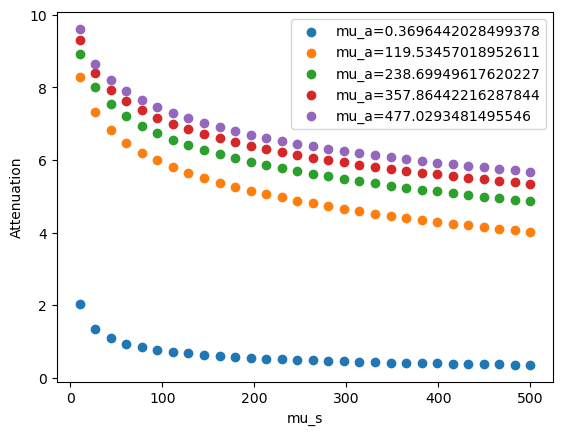

In [21]:
for mu_a in mu_a_samples:
    attenuation_per_mu_a = []
    for i, mu_s in enumerate(mu_s_vals):
        photon_data = function_data_loaded[f"arr_{i + 3}"]
        photon_ppath = photon_data[0, :]
        #photon_nscat = photon_data[1, :]
        photon_weights = np.exp(-mu_a * photon_ppath)
        attenuation = -np.log(np.sum(photon_weights) / nphoton)
        attenuation_per_mu_a.append(attenuation)

    plt.scatter(mu_s_vals, attenuation_per_mu_a, label=f"mu_a={mu_a}")
plt.legend()
plt.xlabel("mu_s")
plt.ylabel("Attenuation")


Same plot but with randomly sampled, then interpolated values for mu_s...

In [16]:
mcs_obj = SimulationAttenuation(config.mcs_func_path)

Loaded data with 100000.0 photons and 30 values for mu_s.


Text(0, 0.5, 'Attenuation')

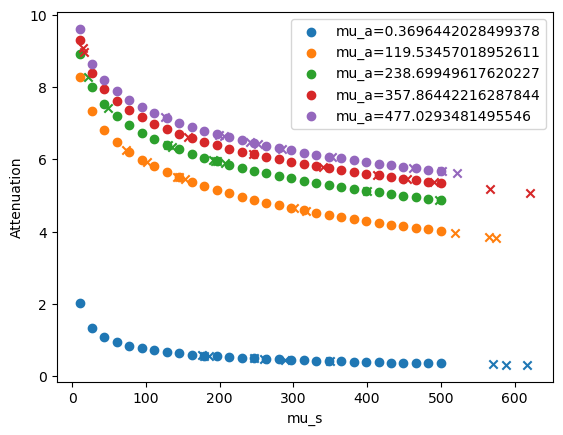

In [17]:
for mu_a in mu_a_samples:
    attenuation_per_mu_a = []
    for i, mu_s in enumerate(mu_s_vals):
        photon_data = function_data_loaded[f"arr_{i + 3}"]
        photon_ppath = photon_data[0, :]
        #photon_nscat = photon_data[1, :]
        photon_weights = np.exp(-mu_a * photon_ppath)
        attenuation = -np.log(np.sum(photon_weights) / nphoton)
        attenuation_per_mu_a.append(attenuation)
    
    p = plt.scatter(mu_s_vals, attenuation_per_mu_a, label=f"mu_a={mu_a}")

    mu_s_vals_sampled = np.random.rand(10) * (mu_s_vals[-1] - mu_s_vals[0]) * 1.25 + mu_s_vals[0]
    attenuation_interpolated =  mcs_obj.A(mu_a, mu_s_vals_sampled)
    plt.scatter(mu_s_vals_sampled, attenuation_interpolated, marker="x", color=p.get_facecolor()[0])

    
plt.legend()
plt.xlabel("mu_s")
plt.ylabel("Attenuation")

Sampe graph, but compare with attenuation based on perturbation Monte Carlo method, with mean mu_a, mu_s values as baseline.
This barely works because of overflows.

In [20]:
mu_a_baseline = mu_a_samples[len(mu_a_samples)//2]
mu_s_baseline = mu_s_vals[-1]
photon_ppath_baseline, photon_nscat_baseline = function_data_loaded[f"arr_{2 + len(mu_s_vals) - 1}"][:, :]
weights_baseline = np.exp(-mu_a_baseline * photon_ppath_baseline)

In [21]:
np.max(photon_ppath_baseline)

217.23641967773438

/tmp/ipykernel_2956459/75497598.py:16: RuntimeWarning: overflow encountered in exp
  photon_weights_perturbed *= np.exp(-(mu_s_vals_sampled - mu_s_baseline)[:, None] * photon_ppath_baseline[None, :])
/tmp/ipykernel_2956459/75497598.py:16: RuntimeWarning: invalid value encountered in multiply
  photon_weights_perturbed *= np.exp(-(mu_s_vals_sampled - mu_s_baseline)[:, None] * photon_ppath_baseline[None, :])
/tmp/ipykernel_2956459/75497598.py:17: RuntimeWarning: overflow encountered in exp
  photon_weights_perturbed *= np.exp(-(mu_a - mu_a_baseline) * photon_ppath_baseline[None, :])
/tmp/ipykernel_2956459/75497598.py:17: RuntimeWarning: invalid value encountered in multiply
  photon_weights_perturbed *= np.exp(-(mu_a - mu_a_baseline) * photon_ppath_baseline[None, :])


Text(0, 0.5, 'Attenuation')

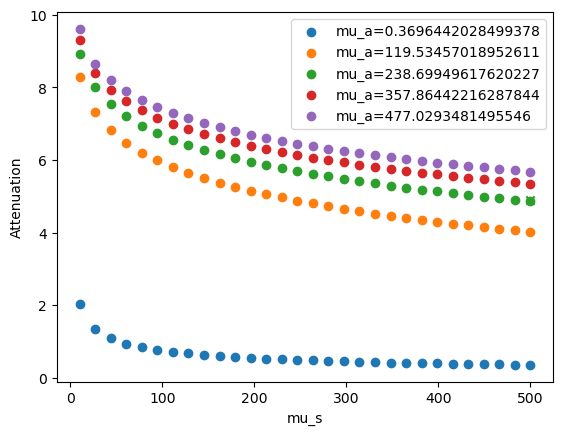

In [22]:
for mu_a in mu_a_samples:
    attenuation_per_mu_a = []
    attenuation_per_mu_a_perturbed = []
    for i, mu_s in enumerate(mu_s_vals):
        photon_data = function_data_loaded[f"arr_{i + 3}"]
        photon_ppath = photon_data[0, :]
        #photon_nscat = photon_data[1, :]
        photon_weights = np.exp(-mu_a * photon_ppath)
        attenuation = -np.log(np.sum(photon_weights) / nphoton)
        attenuation_per_mu_a.append(attenuation)

    p = plt.scatter(mu_s_vals, attenuation_per_mu_a, label=f"mu_a={mu_a}")

    mu_s_vals_sampled = np.random.rand(10) * (mu_s_vals[-1] - mu_s_vals[0]) + mu_s_vals[0]
    photon_weights_perturbed = weights_baseline[None, :] * np.power((mu_s_vals_sampled/mu_s_baseline)[:, None], photon_nscat_baseline[None, :])
    photon_weights_perturbed *= np.exp(-(mu_s_vals_sampled - mu_s_baseline)[:, None] * photon_ppath_baseline[None, :])
    photon_weights_perturbed *= np.exp(-(mu_a - mu_a_baseline) * photon_ppath_baseline[None, :])
    attenuation_perturbed = -np.log(np.sum(photon_weights_perturbed, axis=-1) / nphoton)

    plt.scatter(mu_s_vals_sampled, attenuation_perturbed, marker="x", color=p.get_facecolor()[0])

    
plt.legend()
plt.xlabel("mu_s")
plt.ylabel("Attenuation")

### Test how many photons need to be stored for good results.

1e5 photons resulted in 44MB of data. Therefore, only try up to 2^21 photons which should result in about 1GB of data.

In [11]:
for nphoton in [2**j for j in range(10, 22, 2)]:
    print(f"-----------Generating data for {nphoton} photons.------------------")
    cfg["nphoton"] = nphoton
    cfg["maxdetphoton"] = nphoton
    function_data = []
    function_data.append(cfg["nphoton"])
    function_data.append(cfg["prop"][1, 2])
    function_data.append(mu_s_vals)
    for i, mu_s in enumerate(mu_s_vals):
        cfg["prop"][1, 1] = mu_s / 10 # mu_s_vals are stored in cm^-1
        cfg["prop"][1, 0] = 0
        cfg["prop"][1, 2] = g_combined
        cfg["prop"][1, 3] = refractive_index_combined
        res = pmcx.mcxlab(cfg)
        cur_photon_data = np.row_stack(
            (
                res["detp"]["ppath"][:, 0] * cfg["unitinmm"] / 10, # store pathlength in cm. pathlengths are stored in "unitinmm"
                res["detp"]["nscat"][:, 0]
            )
        )
        function_data.append(cur_photon_data)
    fpath = config.mcs_func_path.parent / f"function_data{nphoton}.npz"
    np.savez(fpath, *function_data)

ource 1, normalization factor alpha=0.095367
data normalization complete : 6022 ms
simulated 1048576 photons (1048576) with 147456 threads (repeat x1)
MCX simulation speed: 175.91 photon/ms
total simulated energy: 1048576.00	absorbed: 0.00000%
(loss due to initial specular reflection is excluded in the total)
###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS u

nphoton: 1.04858e+06
tstart: 0
tstep: 1e-07
tend: 1e-07
maxdetphoton: 1.04858e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 10


                                      #
#Please visit our free scientific data sharing portal at https://neurojson.io #
# and consider sharing your public datasets in standardized JSON/JData format #
###############################################################################
$Rev::0fcc04 $ v2025 $Date::2025-02-12 23:26:11 -05$ by $Author::Qianqian Fang$
###############################################################################
- code name: [Fermi MCX] compiled by nvcc [9.2] for CUDA-arch [350] on [Feb 13 2025]
- compiled with: RNG [xorshift128+] with Seed Length [4]

GPU=4 (Quadro RTX 8000) threadph=7 extra=16384 np=1048576 nthread=147456 maxgate=1 repetition=1
initializing streams ...	init complete : 2 ms
requesting 1792 bytes of shared memory
launching MCX simulation for time window [0.00e+00ns 1.00e+02ns] ...
simulation run# 1 ... 
kernel complete:  	6339 ms
retrieving fields ... 	detected 1040151 photons, total: 1040151	transfer complete:	6368 ms
normalizing raw data ...	s

nphoton: 1.04858e+06
tstart: 0
tstep: 1e-07
tend: 1e-07
maxdetphoton: 1.04858e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

nphoton: 1.04858e+06
tstart: 0
tstep: 1e-07
tend: 1e-07
maxdetphoton: 1.04858e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

nphoton: 1.04858e+06
tstart: 0
tstep: 1e-07
tend: 1e-07
maxdetphoton: 1.04858e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

In [7]:
loader = data_loader.DataLoader(None, 520, 900)
mu_a_matrix = loader.absorption_coefs(
    use_diff_oxycco=False,
    use_water_and_fat=True
)

Loaded data with 1024 photons and 30 values for mu_s.
Loaded data with 4096 photons and 30 values for mu_s.
Loaded data with 16384 photons and 30 values for mu_s.
Loaded data with 65536 photons and 30 values for mu_s.
Loaded data with 262144 photons and 30 values for mu_s.
Loaded data with 1048576 photons and 30 values for mu_s.
[0.011711716651916504, 0.05372917652130127, 0.2270352840423584, 0.8735984563827515, 6.201351881027222, 31.095006704330444]


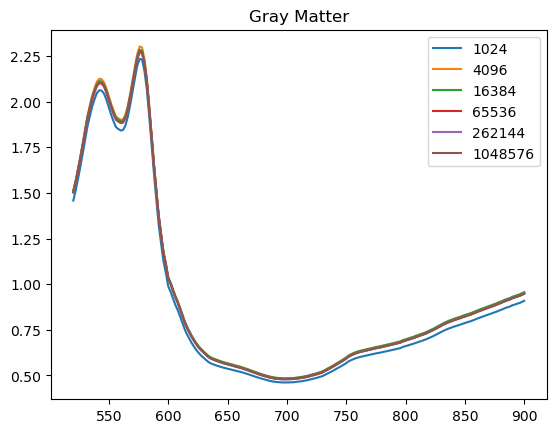

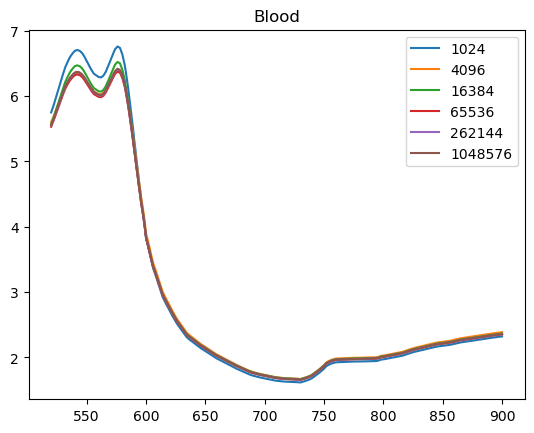

In [9]:
spectra_gm, spectra_blood, times = [], [], []
for nphoton in [2**j for j in range(10, 22, 2)]:
    fpath = config.mcs_func_path.parent / f"function_data{nphoton}.npz"
    mcs_obj = SimulationAttenuation(fpath)
    t0 = time.time()
    spectra_gm.append(mcs_obj.A_concentrations(
        loader.wavelengths,
        mu_a_matrix,
        loader.params_ref_gray_matter[:6],
        *loader.params_ref_gray_matter[-2:]
        )
    )

    spectra_blood.append(mcs_obj.A_concentrations(
        loader.wavelengths,
        mu_a_matrix,
        loader.params_ref_blood_vessel[:6],
        *loader.params_ref_blood_vessel[-2:]
    ))
    t1 = time.time()
    times.append((t1 - t0) / 2)
labels = [str(nphoton) for nphoton in [2**i for i in range(10, 22, 2)]]
plot_spectra(spectra_gm, loader.wavelengths, labels, title="Gray Matter")
plot_spectra(spectra_blood, loader.wavelengths, labels, title="Blood")
print(times)

Result: Spectra are almost identical for more than 1e4 photons. Interestingly, 4k photons make very similar spectrum, but 16k photons are noticeably worse. 5e4 photons should be enough. 

In [11]:
print([t*(24/381) for t in times]) # times for one function evaluation when using 24 wavelengths

[0.0007377459308293861, 0.0033845150564599225, 0.01430143521526667, 0.05502982402411033, 0.3906363389623447, 1.958740579800343]


### Test how long simulation should run

Simulation should require the longest time (for all backscattered photons to reach the detector) when scattering is at its lowest, because then the pathlength should be its highest. (See e.g. Jacques' model).
Let's compare how the number of captured photons changes when simulation time is reduced.
**Make sure to 'reset' configuration with cell where it is defined!**

In [16]:
ndetected = []
for simtime in np.logspace(-10, -6, 20):
    cfg["tend"] = simtime
    cfg["tstep"] = simtime
    cfg["prop"][1, 1] = mu_s_vals[-1] / 10 # mu_s_vals are stored in cm^-1
    cfg["prop"][1, 0] = 0
    cfg["prop"][1, 2] = g_combined
    cfg["prop"][1, 3] = refractive_index_combined
    res = pmcx.mcxlab(cfg)
    ndetected.append(res["detp"]["ppath"].shape[0])

nphoton: 50000
tstart: 0
tstep: 1e-10
tend: 1e-10
maxdetphoton: 50000
issrcfrom0: 1
autopilot: 1
unitinmm: 10
nphoton: 50000
tstart: 0
tstep: 1.62378e-10
tend: 1.62378e-10
maxdetphoton: 50000
issrcfrom0: 1
autopilot: 1
unitinmm: 10
nphoton: 50000
tstart: 0
tstep: 2.63665e-10
tend: 2.63665e-10
maxdetphoton: 50000
issrcfrom0: 1
autopilot: 1
unitinmm: 10
nphoton: 50000
tstart: 0
tstep: 4.28133e-10
tend: 4.28133e-10
maxdetphoton: 50000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

nphoton: 50000
tstart: 0
tstep: 6.95193e-10
tend: 6.95193e-10
maxdetphoton: 50000
issrcfrom0: 1
autopilot: 1
unitinmm: 10
nphoton: 50000
tstart: 0
tstep: 1.12884e-09
tend: 1.12884e-09
maxdetphoton: 50000
issrcfrom0: 1
autopilot: 1
unitinmm: 10
nphoton: 50000
tstart: 0
tstep: 1.83298e-09
tend: 1.83298e-09
maxdetphoton: 50000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

nphoton: 50000
tstart: 0
tstep: 2.97635e-09
tend: 2.97635e-09
maxdetphoton: 50000
issrcfrom0: 1
autopilot: 1
unitinmm: 10
nphoton: 50000
tstart: 0
tstep: 4.83293e-09
tend: 4.83293e-09
maxdetphoton: 50000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

nphoton: 50000
tstart: 0
tstep: 7.8476e-09
tend: 7.8476e-09
maxdetphoton: 50000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

nphoton: 50000
tstart: 0
tstep: 1.27427e-08
tend: 1.27427e-08
maxdetphoton: 50000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


 normalization factor alpha=25.485498
data normalization complete : 223 ms
simulated 50000 photons (50000) with 147456 threads (repeat x1)
MCX simulation speed: 284.09 photon/ms
total simulated energy: 50000.00	absorbed: 0.00000%
(loss due to initial specular reflection is excluded in the total)


nphoton: 50000
tstart: 0
tstep: 2.06914e-08
tend: 2.06914e-08
maxdetphoton: 50000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

nphoton: 50000
tstart: 0
tstep: 3.35982e-08
tend: 3.35982e-08
maxdetphoton: 50000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


 normalization factor alpha=9.665860
data normalization complete : 405 ms
simulated 50000 photons (50000) with 147456 threads (repeat x1)
MCX simulation speed: 139.66 photon/ms
total simulated energy: 50000.00	absorbed: 0.00000%
(loss due to initial specular reflection is excluded in the total)


nphoton: 50000
tstart: 0
tstep: 5.45559e-08
tend: 5.45559e-08
maxdetphoton: 50000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

nphoton: 50000
tstart: 0
tstep: 8.85867e-08
tend: 8.85867e-08
maxdetphoton: 50000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

nphoton: 50000
tstart: 0
tstep: 1.43845e-07
tend: 1.43845e-07
maxdetphoton: 50000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

nphoton: 50000
tstart: 0
tstep: 2.33572e-07
tend: 2.33572e-07
maxdetphoton: 50000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


                                      #
#Please visit our free scientific data sharing portal at https://neurojson.io #
# and consider sharing your public datasets in standardized JSON/JData format #
###############################################################################
$Rev::0fcc04 $ v2025 $Date::2025-02-12 23:26:11 -05$ by $Author::Qianqian Fang$
###############################################################################
- code name: [Fermi MCX] compiled by nvcc [9.2] for CUDA-arch [350] on [Feb 13 2025]
- compiled with: RNG [xorshift128+] with Seed Length [4]

GPU=4 (Quadro RTX 8000) threadph=0 extra=50000 np=50000 nthread=147456 maxgate=1 repetition=1
initializing streams ...	init complete : 1 ms
requesting 1792 bytes of shared memory
launching MCX simulation for time window [0.00e+00ns 1.44e+02ns] ...
simulation run# 1 ... 
kernel complete:  	1929 ms
retrieving fields ... 	detected 49691 photons, total: 49691	transfer complete:	1934 ms
normalizing raw data ...	source 

nphoton: 50000
tstart: 0
tstep: 3.79269e-07
tend: 3.79269e-07
maxdetphoton: 50000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

nphoton: 50000
tstart: 0
tstep: 6.15848e-07
tend: 6.15848e-07
maxdetphoton: 50000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

nphoton: 50000
tstart: 0
tstep: 1e-06
tend: 1e-06
maxdetphoton: 50000
issrcfrom0: 1
autopilot: 1
unitinmm: 10


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

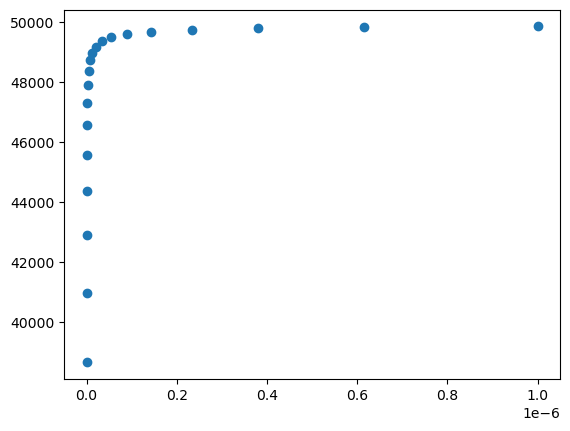

In [18]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(np.logspace(-10, -6, 20), ndetected, label="o")
#ax.set_xscale("log")

A simulation time of 5e7 seconds should be enough for most photons to reach the detector.